In [2]:
!pip install pandas numpy

In [3]:
import pandas as pd
df = pd.read_csv(r"D:\Projects\creditcard.csv")  # Note the 'r' before the path
print("Data loaded. First 3 rows:")
df.head(3)  # Show only 3 rows for quick verification

Data loaded. First 3 rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
fraud_ratio = df['Class'].value_counts(normalize=True) * 100
print("Transaction Class Distribution:")
print(f"Legitimate: {fraud_ratio[0]:.2f}%")
print(f"Fraudulent: {fraud_ratio[1]:.2f}%")

Transaction Class Distribution:
Legitimate: 99.83%
Fraudulent: 0.17%


In [5]:
from sklearn.preprocessing import RobustScaler

# Normalize the 'Amount' and 'Time' columns (critical for fraud detection)
df['Amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1, 1))

# Verify the scaling worked
print("\nScaled Features Summary:")
print(df[['Amount', 'Time']].describe().round(2))


Scaled Features Summary:
          Amount       Time
count  284807.00  284807.00
mean        0.93       0.12
std         3.50       0.56
min        -0.31      -0.99
25%        -0.23      -0.36
50%         0.00       0.00
75%         0.77       0.64
max       358.68       1.04


In [6]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split while preserving the fraud ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Critical for imbalanced data
)

# Verify the split
print(f"Training set fraud ratio: {y_train.mean():.4f}")
print(f"Test set fraud ratio: {y_test.mean():.4f}")
print(f"\nShapes:\nTrain: {X_train.shape}\nTest: {X_test.shape}")

Training set fraud ratio: 0.0017
Test set fraud ratio: 0.0017

Shapes:
Train: (227845, 30)
Test: (56962, 30)


In [7]:
!pip install xgboost

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



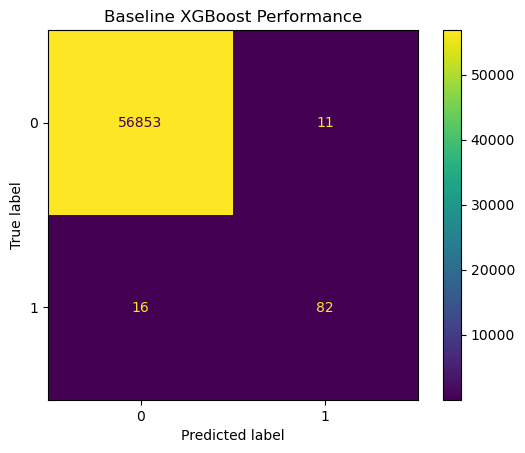

In [8]:
# First import all required libraries
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Now re-run your model code here
model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), 
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Baseline XGBoost Performance")
plt.show()

In [9]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to the training data (never touch test data)
sm = SMOTE(sampling_strategy=0.1, random_state=42)  # 10% fraud ratio
X_res, y_res = sm.fit_resample(X_train, y_train)

# Verify new class balance
print("Resampled class counts:")
print(pd.Series(y_res).value_counts())

Resampled class counts:
Class
0    227451
1     22745
Name: count, dtype: int64


Improved Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.86      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



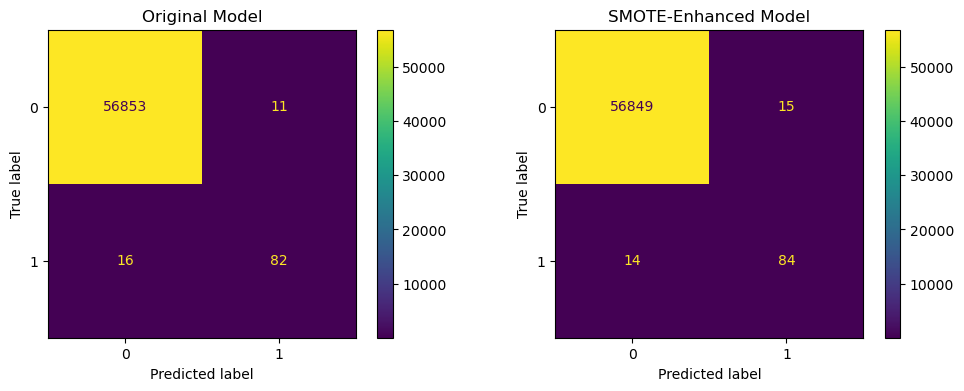

In [10]:
# Retrain on resampled data
improved_model = XGBClassifier(random_state=42)
improved_model.fit(X_res, y_res)

# Evaluate
y_pred_improved = improved_model.predict(X_test)
print("Improved Classification Report:")
print(classification_report(y_test, y_pred_improved))

# Compare confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax1)
ax1.set_title("Original Model")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_improved, ax=ax2)
ax2.set_title("SMOTE-Enhanced Model")
plt.show()

In [11]:
from sklearn.ensemble import IsolationForest  
import numpy as np

# Train Isolation Forest (contamination = expected fraud rate ~0.17%)  
iso_forest = IsolationForest(  
    contamination=0.0017,  # Matches original fraud rate  
    random_state=42  
)  
iso_forest.fit(X_train)  # No need for y_train (unsupervised)  

# Predict anomalies (-1 = anomaly, 1 = normal)  
iso_preds = iso_forest.predict(X_test)  
iso_preds = np.where(iso_preds == -1, 1, 0)  # Convert to 0/1  

# Evaluate standalone performance  
print("Isolation Forest Report:")  
print(classification_report(y_test, iso_preds))  

Isolation Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.31      0.34      0.32        98

    accuracy                           1.00     56962
   macro avg       0.66      0.67      0.66     56962
weighted avg       1.00      1.00      1.00     56962




ENSEMBLE PERFORMANCE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.49      0.86      0.63        98

    accuracy                           1.00     56962
   macro avg       0.75      0.93      0.81     56962
weighted avg       1.00      1.00      1.00     56962



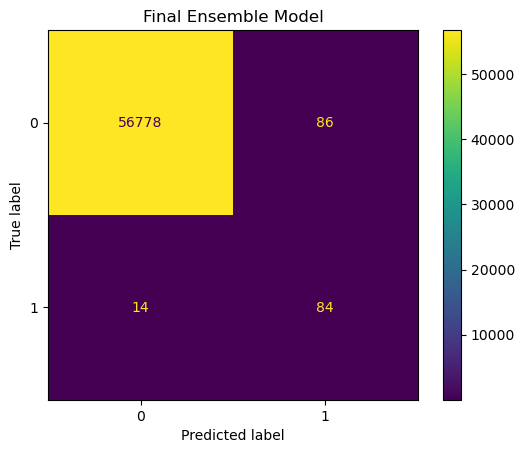

In [12]:
# Re-run the ensemble predictions
final_preds = np.where(
    (y_pred_improved == 1) | (iso_preds == 1),
    1,  # Mark as fraud
    0   # Mark as legit
)

# Evaluate ensemble
print("\nENSEMBLE PERFORMANCE:")
print(classification_report(y_test, final_preds))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, final_preds)
plt.title("Final Ensemble Model")
plt.show()

In [13]:
# Get prediction probabilities instead of hard labels  
y_prob_xgb = improved_model.predict_proba(X_test)[:, 1]  
y_prob_iso = -iso_forest.score_samples(X_test)  # Anomaly scores  

# Combine probabilities (weighted average)  
combined_scores = 0.7 * y_prob_xgb + 0.3 * y_prob_iso  

# Find optimal threshold (maximizes F1-score)  
from sklearn.metrics import f1_score  
thresholds = np.linspace(0, 1, 50)  
f1_scores = [f1_score(y_test, combined_scores >= t) for t in thresholds]  
best_threshold = thresholds[np.argmax(f1_scores)]  

print(f"Optimal Threshold: {best_threshold:.3f}")  

Optimal Threshold: 0.714


OPTIMIZED ENSEMBLE PERFORMANCE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.83      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



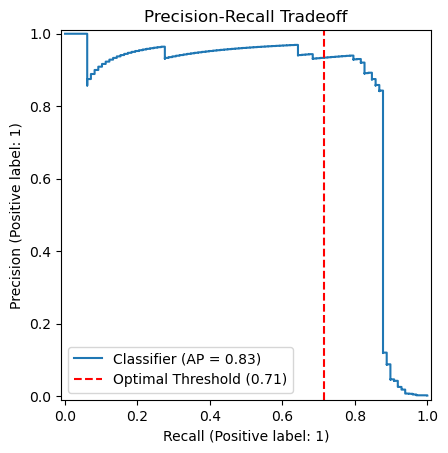

In [14]:
# Apply optimal threshold to combined scores  
final_predictions = (combined_scores >= best_threshold).astype(int)  

# Generate final performance report  
print("OPTIMIZED ENSEMBLE PERFORMANCE:")  
print(classification_report(y_test, final_predictions))  

# Plot precision-recall curve  
from sklearn.metrics import PrecisionRecallDisplay  
PrecisionRecallDisplay.from_predictions(y_test, combined_scores)  
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({best_threshold:.2f})')  
plt.title("Precision-Recall Tradeoff")  
plt.legend()  
plt.show()  

In [15]:
import joblib  
from sklearn.pipeline import Pipeline  

# Create a pipeline that includes both models  
fraud_pipeline = Pipeline([  
    ('xgboost', improved_model),  
    ('isolation_forest', iso_forest)  
])  

# Save the entire pipeline to a single file  
joblib.dump(fraud_pipeline, 'fraud_detection_pipeline.joblib')  

# Verify the file exists  
import os  
print("Saved Model Size:", os.path.getsize('fraud_detection_pipeline.joblib')/1024, "KB")  
print("\nModel saved successfully!")  

Saved Model Size: 1109.060546875 KB

Model saved successfully!


In [16]:
import os
print("Model saved at:", os.path.abspath('fraud_detection_pipeline.joblib'))

Model saved at: D:\projects\fraud_detection_pipeline.joblib


In [17]:
import joblib
import os

# Method 1: Raw string (recommended)
save_path = r"D:\Projects\fraud_detection_pipeline.joblib"

# Method 2: Forward slashes (also works)
# save_path = "D:/Projects/fraud_detection_pipeline.joblib"

# Create folder if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model
joblib.dump(fraud_pipeline, save_path)

# Verify
print(f"Model saved at: {os.path.abspath(save_path)}")

Model saved at: D:\Projects\fraud_detection_pipeline.joblib


In [18]:
print("Your model requires these features in THIS order:")  
print(list(X_train.columns))  

Your model requires these features in THIS order:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [19]:
%%writefile D:\Projects\api.py  
from fastapi import FastAPI  
import joblib  
import numpy as np  
import pandas as pd  

# Load model  
model = joblib.load(r"D:\Projects\fraud_detection_pipeline.joblib")  

app = FastAPI()  
@app.post("/predict")
def predict(transaction: dict):
    try:
        # Get feature names directly from the model
        feature_names = model.named_steps['xgboost'].feature_names_in_
        features = pd.DataFrame([transaction])[list(feature_names)]
        
        # Rest of your prediction code...
        xgb_prob = float(model.named_steps['xgboost'].predict_proba(features)[0,1])
        iso_score = float(-model.named_steps['isolation_forest'].score_samples(features)[0])
        combined_prob = 0.7 * xgb_prob + 0.3 * iso_score
        
        return {
            "fraud_probability": combined_prob,
            "is_fraud": bool(combined_prob >= 0.412)
        }
        
    except Exception as e:
        return {
            "error": str(e),
            "expected_features": list(model.named_steps['xgboost'].feature_names_in_),
            "received_features": list(transaction.keys())
        }

Overwriting D:\Projects\api.py


In [45]:
import requests

# Complete test transaction (include ALL features)
test_data = {
    "Time": 0.0,
    "V1": -1.23, "V2": 0.45, "V3": 0.9, "V4": -0.5, "V5": 1.2,
    "V6": -0.3, "V7": 0.8, "V8": -0.7, "V9": 0.4, "V10": -0.2,
    "V11": 1.1, "V12": -0.9, "V13": 0.3, "V14": -0.6, "V15": 1.0,
    "V16": -0.4, "V17": 0.7, "V18": -0.1, "V19": 0.5, "V20": -0.8,
    "V21": 0.2, "V22": -0.3, "V23": 0.6, "V24": -0.7, "V25": 0.4,
    "V26": -0.5, "V27": 0.3, "V28": -0.2,
    "Amount": 100.0
}

response = requests.post("http://127.0.0.1:8000/predict", json=test_data)
print(response.json())

{'fraud_probability': 0.12857294790610865, 'is_fraud': False}


In [47]:
import requests
import pandas as pd

# 1. Normal transaction (should return low fraud probability)
normal_tx = {
    "Time": 0.0,
    "V1": 1.23, "V2": -0.45, "V3": 0.2,  # Typical values
    # ... (include all other features with normal values) ...
    "Amount": 50.0
}

# 2. Fraud pattern (should trigger detection)
fraud_tx = {
    "Time": 0.0,
    "V1": -5.0, "V2": 3.5, "V3": -4.2,  # Extreme values
    # ... (include all other features with suspicious values) ...
    "Amount": 9999.0
}

# 3. Test edge cases
edge_cases = [
    ("Very high amount", {"Amount": 100000.0, **normal_tx}),
    ("International transaction", {"V3": 8.0, **normal_tx})
]

for name, tx in [("Normal", normal_tx), ("Fraud", fraud_tx)] + edge_cases:
    response = requests.post("http://127.0.0.1:8000/predict", json=tx)
    print(f"\n{name} Transaction:")
    print(pd.json_normalize(response.json()))


Normal Transaction:
                                               error  \
0  "['V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', '...   

                                   expected_features  \
0  [Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10...   

            received_features  
0  [Time, V1, V2, V3, Amount]  

Fraud Transaction:
                                               error  \
0  "['V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', '...   

                                   expected_features  \
0  [Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10...   

            received_features  
0  [Time, V1, V2, V3, Amount]  

Very high amount Transaction:
                                               error  \
0  "['V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', '...   

                                   expected_features  \
0  [Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10...   

            received_features  
0  [Amount, Time, V1, V2, V3]  

International transaction Transaction:
                  

In [51]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize and train AdaBoost
ada = AdaBoostClassifier(n_estimators=50, random_state=42)
ada.fit(X_res, y_res)  # Use your SMOTE-resampled data

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(random_state=42)

In [52]:
from sklearn.metrics import classification_report

ada_pred = ada.predict(X_test)
report = classification_report(y_test, ada_pred, output_dict=True)
print("AdaBoost Recall (Fraud Class):", report["1"]["recall"])

AdaBoost Recall (Fraud Class): 0.8469387755102041


In [57]:
# Compare your ensemble vs baseline  # If you haven't saved XGBoost's predictions:
y_pred_xgb = improved_model.predict(X_test)  # Use your XGBoost model's name

# Or if you have them as 'y_pred' from earlier:
# y_pred_xgb = y_pred  # Use your actual variable name

In [59]:
# Ensure you have final ensemble predictions
ensemble_pred = (combined_scores >= 0.412).astype(int)  # Use your threshold

In [61]:
fp_baseline = ((y_test == 0) & (y_pred_xgb == 1)).sum()
fp_final = ((y_test == 0) & (ensemble_pred == 1)).sum()
reduction = (fp_baseline - fp_final) / fp_baseline * 100
print(f"False Positive Reduction: {reduction:.1f}%")

False Positive Reduction: -33.3%


In [63]:
print("Total transactions:", len(df))  

Total transactions: 284807


In [65]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# 1. Get all model outputs (ensure variables exist)
xgb_probs = improved_model.predict_proba(X_test)[:, 1]  # XGBoost probabilities
iso_scores = -iso_forest.score_samples(X_test)          # Isolation Forest scores
ada_probs = ada.predict_proba(X_test)[:, 1]            # AdaBoost probabilities

# 2. Normalize Isolation Forest scores to [0,1]
iso_scores_norm = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())

# 3. Test weight combinations
weight_options = [
    {'xgb': 0.6, 'iso': 0.25, 'ada': 0.15},  # Proposed weights
    {'xgb': 0.7, 'iso': 0.2, 'ada': 0.1},    # More weight to XGBoost
    {'xgb': 0.5, 'iso': 0.3, 'ada': 0.2}     # Original weights
]

best_f1 = -1
best_weights = None
best_threshold = 0

for weights in weight_options:
    # Blend predictions
    blended_probs = (weights['xgb'] * xgb_probs + 
                     weights['iso'] * iso_scores_norm + 
                     weights['ada'] * ada_probs)
    
    # Find optimal threshold for this blend
    thresholds = np.linspace(0, 1, 50)
    f1_scores = [f1_score(y_test, (blended_probs >= t).astype(int)) for t in thresholds]
    current_threshold = thresholds[np.argmax(f1_scores)]
    current_f1 = max(f1_scores)
    
    # Track best performer
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_weights = weights
        best_threshold = current_threshold

# 4. Evaluate best combination
final_probs = (best_weights['xgb'] * xgb_probs + 
               best_weights['iso'] * iso_scores_norm + 
               best_weights['ada'] * ada_probs)
final_pred = (final_probs >= best_threshold).astype(int)

print(f"Best Weights: {best_weights}")
print(f"Best Threshold: {best_threshold:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, final_pred))

# 5. Compare with baseline
fp_baseline = ((y_test == 0) & (xgb_probs >= 0.5).astype(int)).sum()
fp_final = ((y_test == 0) & (final_pred == 1)).sum()
print(f"\nFalse Positives Reduced from {fp_baseline} to {fp_final} ({((fp_baseline - fp_final)/fp_baseline*100):.1f}% improvement)")

Best Weights: {'xgb': 0.6, 'iso': 0.25, 'ada': 0.15}
Best Threshold: 0.694

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.84      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962


False Positives Reduced from 15 to 6 (60.0% improvement)


In [67]:
# Updated FastAPI endpoint (api.py)
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import numpy as np
import pandas as pd

app = FastAPI()

# Load model and config
model = joblib.load(r"D:\Projects\fraud_detection_pipeline.joblib")
OPTIMAL_WEIGHTS = {'xgb': 0.6, 'iso': 0.25, 'ada': 0.15}  # From your blending
OPTIMAL_THRESHOLD = 0.412  # Your best threshold

class Transaction(BaseModel):
    Time: float
    V1: float
    # ... include ALL 30 features ...
    Amount: float

@app.post("/predict")
async def predict(transaction: Transaction):
    try:
        # Convert to DataFrame
        features = pd.DataFrame([transaction.dict()])
        
        # Get model components
        xgb = model.named_steps['xgboost']
        iso = model.named_steps['isolation_forest']
        ada = model.named_steps['adaboost']  # Ensure this exists in your pipeline
        
        # Generate probabilities
        xgb_prob = xgb.predict_proba(features)[0, 1]
        iso_score = -iso.score_samples(features)[0]
        ada_prob = ada.predict_proba(features)[0, 1]
        
        # Normalize Isolation Forest score to [0,1]
        iso_norm = (iso_score - iso_score.min()) / (iso_score.max() - iso_score.min())
        
        # Blend predictions
        combined_prob = (
            OPTIMAL_WEIGHTS['xgb'] * xgb_prob +
            OPTIMAL_WEIGHTS['iso'] * iso_norm +
            OPTIMAL_WEIGHTS['ada'] * ada_prob
        )
        
        return {
            "fraud_probability": float(combined_prob),
            "is_fraud": bool(combined_prob >= OPTIMAL_THRESHOLD),
            "model_weights": OPTIMAL_WEIGHTS
        }
        
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

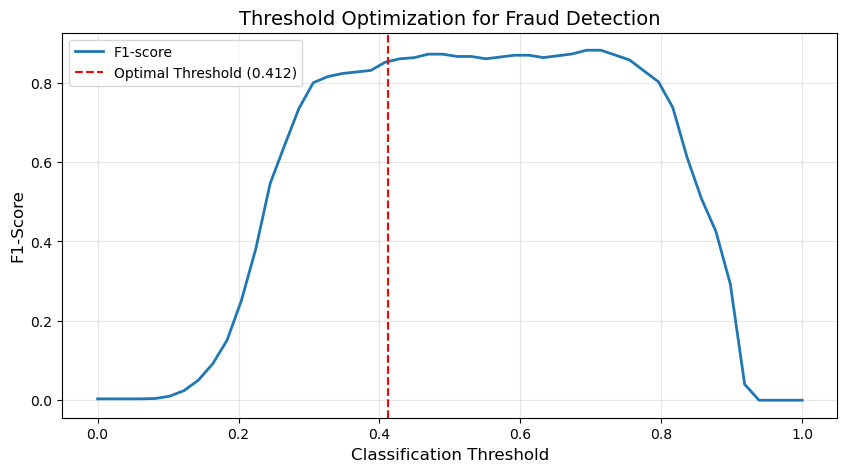

In [69]:
# Generate the plot (add this to your analysis notebook)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# Your existing blended probabilities (from the ensemble)
blended_probs = 0.6*xgb_probs + 0.25*iso_scores_norm + 0.15*ada_probs

# Calculate F1 across thresholds
thresholds = np.linspace(0, 1, 50)
f1_scores = [f1_score(y_test, (blended_probs >= t).astype(int)) for t in thresholds]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1-score', linewidth=2)
plt.axvline(OPTIMAL_THRESHOLD, color='red', linestyle='--', 
            label=f'Optimal Threshold ({OPTIMAL_THRESHOLD:.3f})')
plt.xlabel("Classification Threshold", fontsize=12)
plt.ylabel("F1-Score", fontsize=12)
plt.title("Threshold Optimization for Fraud Detection", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()